<a href="https://colab.research.google.com/github/Louisfhgr/TS_Projekt/blob/main/French__bakery_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
%pip install pmdarima

In [181]:
%pip install wbdata

In [129]:

%pip install pytrends

In [130]:
# System und allgemeine Bibliotheken
import os
import sys
import random
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Datenvisualisierung
import matplotlib.pyplot as plt
import seaborn as sns



# Skalierung und Modellierung
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Zeitreihenanalyse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from sklearn.metrics import mean_absolute_error

In [131]:
# Ordnerstruktur ausgeben
print("Aktueller Ordneraufbau:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Aktueller Ordneraufbau:
./
    Bakery sales.csv
    .config/
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        config_sentinel
        active_config
        .last_update_check.json
        .last_opt_in_prompt.yaml
        .last_survey_prompt.yaml
        gce
        default_configs.db
        logs/
            2024.12.19/
                14.20.18.151587.log
                14.20.05.781718.log
                14.20.30.129972.log
                14.20.16.940511.log
                14.19.43.316528.log
                14.20.29.520330.log
        configurations/
            config_default
    sample_data/
        anscombe.json
        README.md
        california_housing_test.csv
        california_housing_train.csv
        mnist_train_small.csv
        mnist_test.csv


In [132]:
# https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales
df_bakery_raw = pd.read_csv('Bakery sales.csv')

In [133]:
df_Process = df_bakery_raw.copy()

In [134]:
df_Process

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [135]:
# Sicherstellen, dass alle relevanten Spalten Strings sind
df_Process['unit_price'] = df_Process['unit_price'].astype(str)
df_Process['Quantity'] = df_Process['Quantity'].astype(str)

In [136]:
# Umwandlung von Strings in numerische Formate
df_Process['unit_price'] = df_Process['unit_price'].str.replace(',', '.').str.replace(' €', '').astype(float)
df_Process['Quantity'] = df_Process['Quantity'].astype(float)
df_Process['date'] = pd.to_datetime(df_Process['date'])

In [137]:
# Umsatzspalte berechnen
df_Process['revenue'] = df_Process['Quantity'] * df_Process['unit_price']

# Explorative Datenanalyse

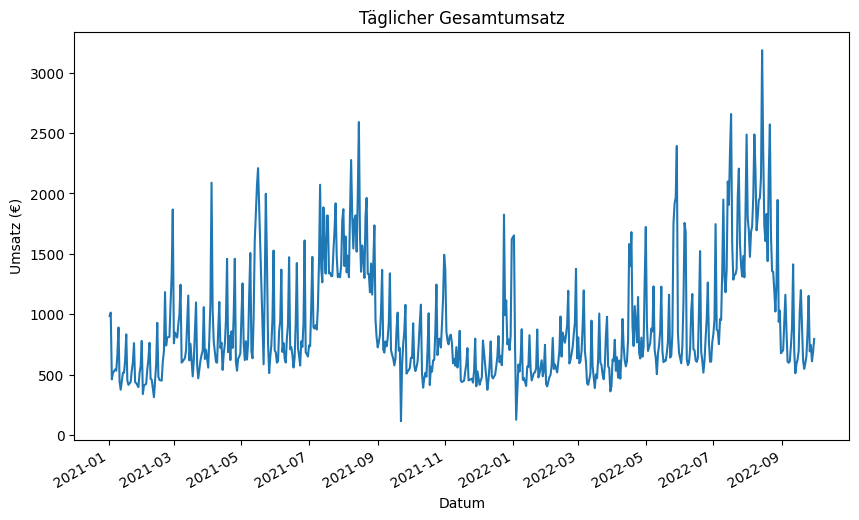

In [138]:
# Gesamtumsatz pro Tag
daily_revenue = df_Process.groupby('date')['revenue'].sum()
daily_revenue.plot(title='Täglicher Gesamtumsatz', figsize=(10, 6))
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.show()

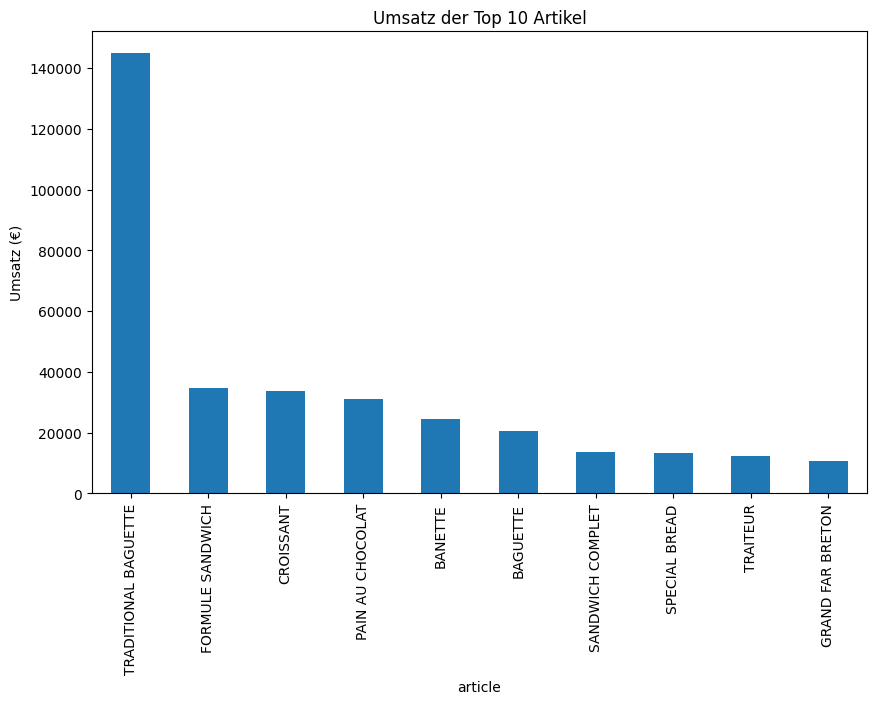

In [139]:
# Umsatz pro Artikel
article_revenue = df_Process.groupby('article')['revenue'].sum().sort_values(ascending=False)
article_revenue.head(10).plot(kind='bar', title='Umsatz der Top 10 Artikel', figsize=(10, 6))
plt.ylabel('Umsatz (€)')
plt.show()

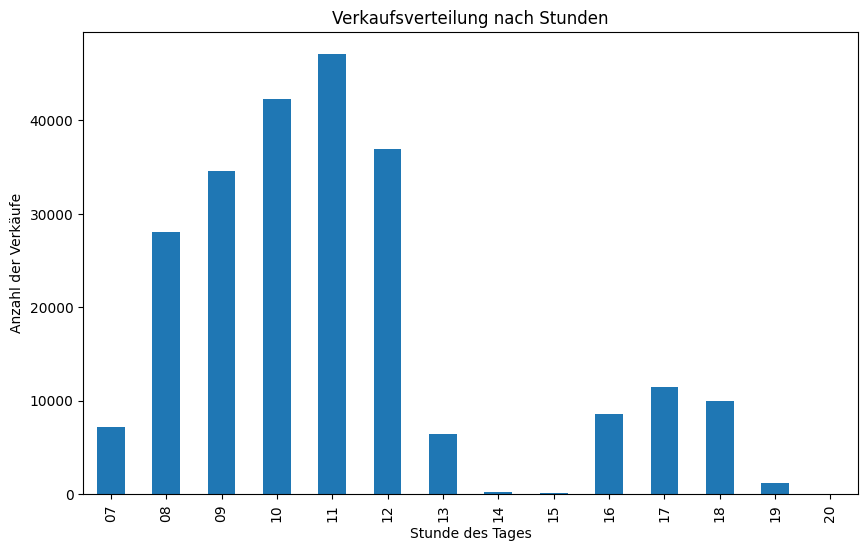

In [140]:
# Verkaufsverteilung über den Tag
hourly_distribution = df_Process['time'].str[:2].value_counts().sort_index()
hourly_distribution.plot(kind='bar', title='Verkaufsverteilung nach Stunden', figsize=(10, 6))
plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl der Verkäufe')
plt.show()

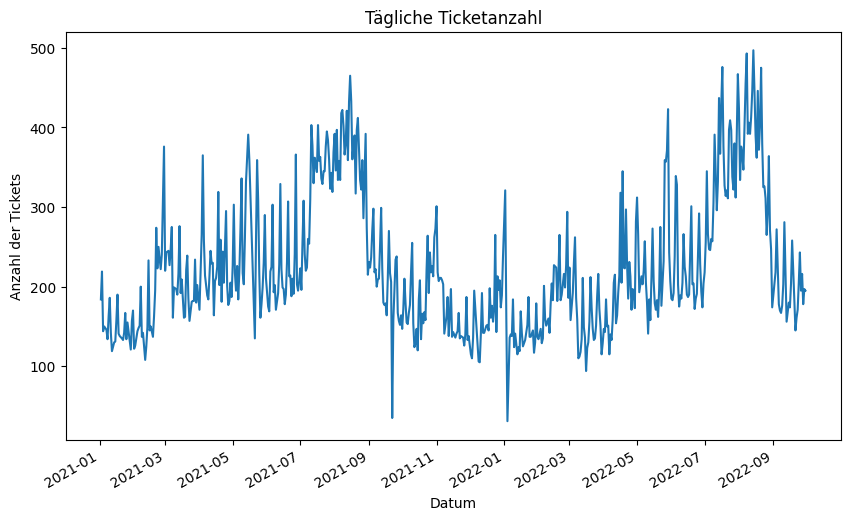

In [141]:
#Ticketanzahl pro Tag
tickets_per_day = df_Process.groupby('date')['ticket_number'].nunique()
tickets_per_day.plot(title='Tägliche Ticketanzahl', figsize=(10, 6))
plt.xlabel('Datum')
plt.ylabel('Anzahl der Tickets')
plt.show()

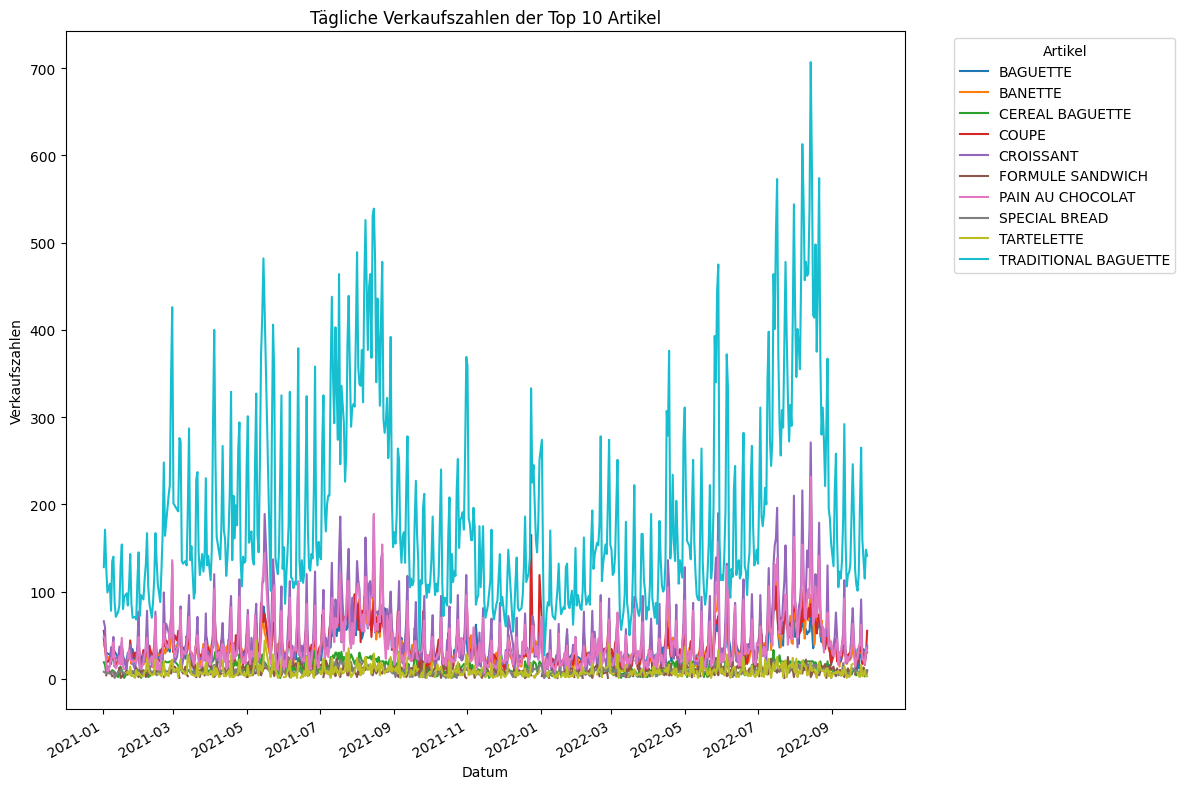

In [142]:
# Verkaufszahlen für die Top 10 Artikel pro Tag (Tabellarisch und Diagramm)
top_10_articles = df_Process.groupby('article')['Quantity'].sum().nlargest(10).index
articles_daily_sales = df_Process[df_Process['article'].isin(top_10_articles)].groupby(['date', 'article'])['Quantity'].sum().unstack()


articles_daily_sales.plot(kind='line', title='Tägliche Verkaufszahlen der Top 10 Artikel', figsize=(12, 8))
plt.xlabel('Datum')
plt.ylabel('Verkaufszahlen')
plt.legend(title='Artikel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [143]:
# 5. Verkaufszahlen für jeden Artikel pro Tag (Tabellarisch)
articles_daily_sales = df_Process.groupby(['article'])['Quantity'].sum()
articles_daily_sales

,Quantity
article,
.,7.0
12 MACARON,70.0
ARMORICAIN,3.0
ARTICLE 295,1.0
BAGUETTE,22053.0
...,...
TROPEZIENNE,508.0
TROPEZIENNE FRAMBOISE,33.0
TULIPE,2.0


# Datenvorebereitung

In [144]:

def check_stationarity(time_series):
    result = adfuller(time_series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] > 0.05:
        print("Die Zeitreihe ist nicht stationär.")
    else:
        print("Die Zeitreihe ist stationär.")

In [145]:
# Überprüfung der Stationarität
print("Stationarität der Originalzeitreihe:")
check_stationarity(daily_revenue.dropna())

Stationarität der Originalzeitreihe:
ADF Statistic: -3.12940476781708
p-value: 0.02445225873218421
Critical Values: {'1%': -3.4415777369651717, '5%': -2.866493255736561, '10%': -2.569407951640003}
Die Zeitreihe ist stationär.


In [146]:
df_Process['trend'] = daily_revenue.rolling(window=30, center=True).mean()

In [147]:
# Varianz und Mittelwert von Saisonalität und Trend
print("Varianz des Trends:", trend.var())
print("Mittelwert der Saisonalität:", seasonal.mean())


Varianz des Trends: 112416.62180001126
Mittelwert der Saisonalität: -1.4210854715202004e-16


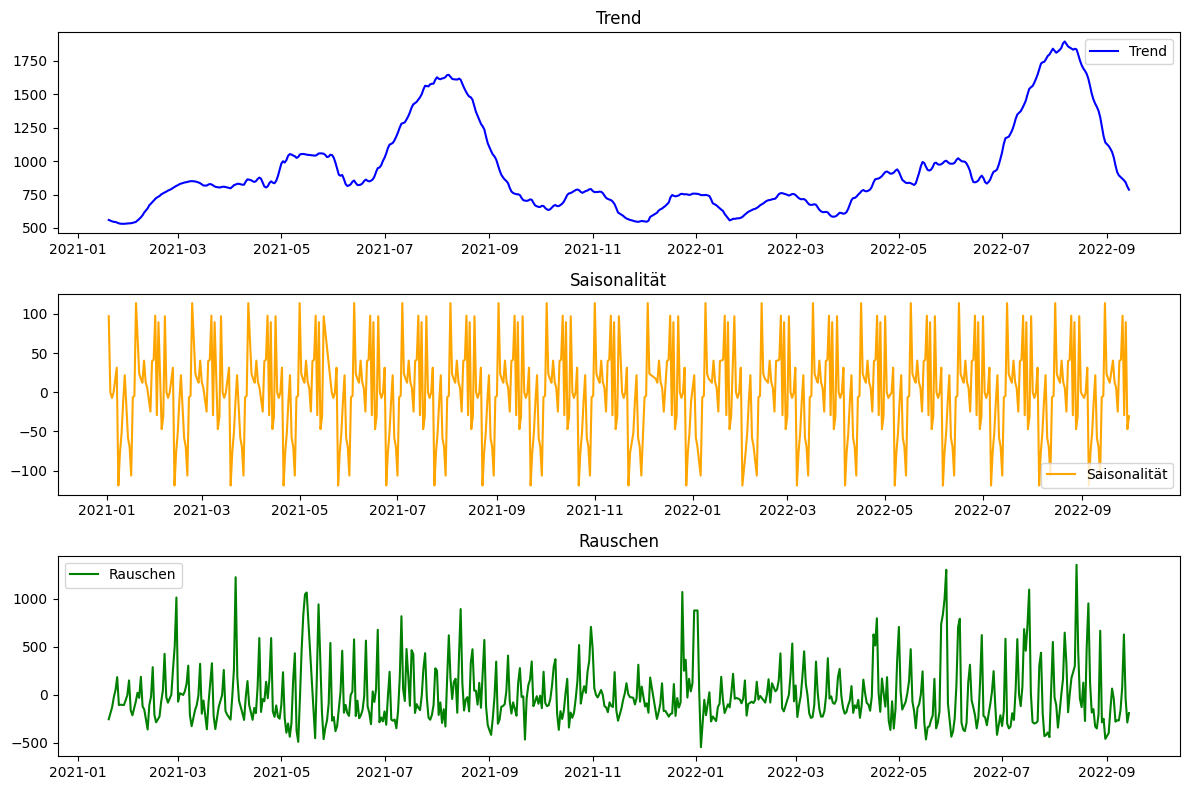

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Zeitreihenanalyse
decomposition = seasonal_decompose(daily_revenue, model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Trend und Saisonalität anzeigen
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

plt.subplot(312)
plt.plot(seasonal, label='Saisonalität', color='orange')
plt.title('Saisonalität')
plt.legend()

plt.subplot(313)
plt.plot(residual, label='Rauschen', color='green')
plt.title('Rauschen')
plt.legend()

plt.tight_layout()
plt.show()


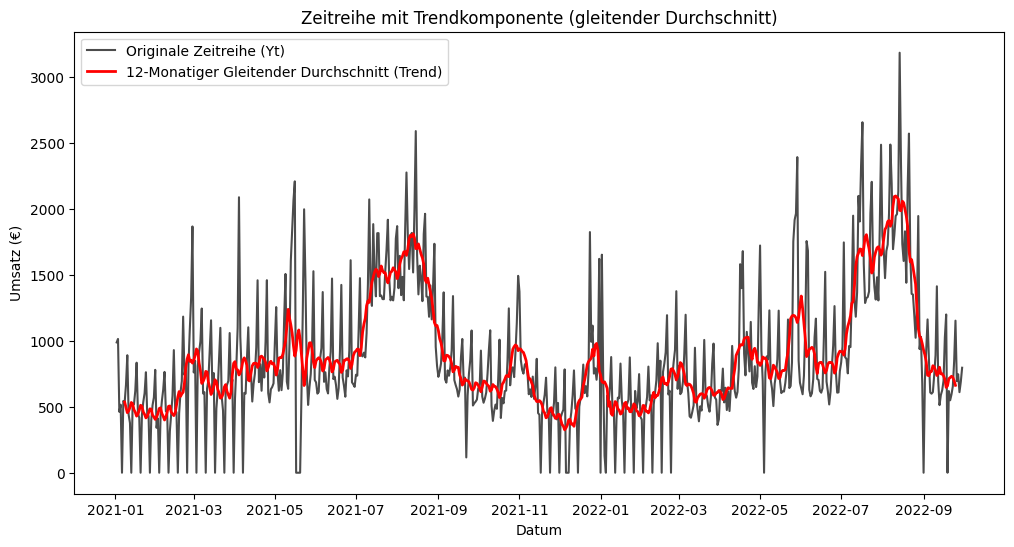

In [149]:
#Decomposition

# Daten vorbereiten
df_bakery_raw = df_bakery_raw.copy()

# Einheitspreise und Mengen bereinigen
df_bakery_raw['unit_price'] = df_bakery_raw['unit_price'].str.replace(',', '.').str.replace(' €', '').astype(float)
df_bakery_raw['Quantity'] = df_bakery_raw['Quantity'].astype(float)

# Umsatz pro Transaktion berechnen
df_bakery_raw['revenue'] = df_bakery_raw['Quantity'] * df_bakery_raw['unit_price']

# Umsatz pro Tag aggregieren
daily_revenue = df_bakery_raw.groupby('date')['revenue'].sum().reset_index()
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])
daily_revenue.set_index('date', inplace=True)
daily_revenue = daily_revenue.asfreq('D').fillna(0)

# Gleitender Durchschnitt für Trendermittlung
window_size = 12  # Fenstergröße für gleitenden Durchschnitt
trend_k_moving_avg = daily_revenue['revenue'].rolling(window=window_size, center=True).mean()

# Plot der Zeitreihe und des Trends
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['revenue'], label='Originale Zeitreihe (Yt)', color='black', alpha=0.7)
plt.plot(trend_k_moving_avg, label=f'{window_size}-Monatiger Gleitender Durchschnitt (Trend)', color='red', linewidth=2)
plt.title('Zeitreihe mit Trendkomponente (gleitender Durchschnitt)')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()

# Modelle

### ARIMA

ADF Statistic: -2.655863245165528
p-value: 0.08199216288481259
Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9260.339, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9410.758, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9374.716, Time=0.09 sec


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9258.831, Time=0.85 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9371.134, Time=0.10 sec


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9218.348, Time=2.72 sec


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9347.689, Time=0.36 sec


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9167.700, Time=3.06 sec


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9264.665, Time=0.20 sec


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=9142.280, Time=1.11 sec


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=9198.582, Time=0.34 sec


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=9016.680, Time=2.31 sec


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9146.879, Time=1.45 sec


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.94 sec


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9068.672, Time=5.71 sec


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=9014.667, Time=1.31 sec


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=9144.859, Time=0.77 sec


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=9140.286, Time=0.53 sec


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=2.42 sec


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=9165.707, Time=0.47 sec


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=9065.496, Time=1.83 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 31.704 seconds


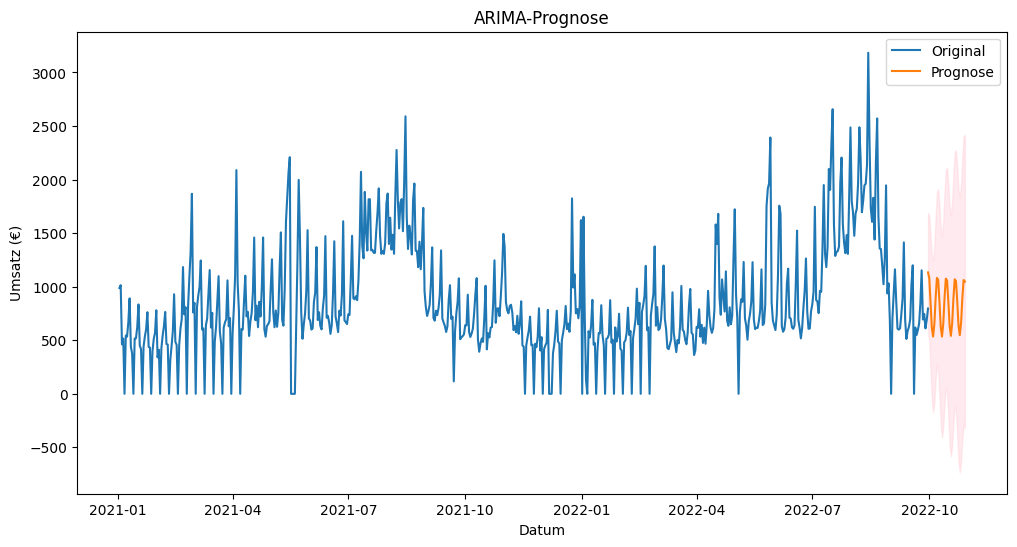

In [150]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, q_stat

# Sicherstellen, dass die Zeitreihe stationär ist
adf_test = adfuller(daily_revenue.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Falls nicht stationär, Differenzbildung durchführen
if adf_test[1] > 0.05:
    daily_revenue_diff = daily_revenue.diff().dropna()
else:
    daily_revenue_diff = daily_revenue

# Optimalen ARIMA-Parameter mit auto_arima finden
stepwise_model = auto_arima(daily_revenue,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)



# ARIMA-Modell mit den gefundenen Parametern trainieren
order = stepwise_model.order
arima_model = ARIMA(daily_revenue, order=order)
arima_result = arima_model.fit()


# Prognose erstellen
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(daily_revenue.index[-1], periods=30, freq='D')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Ergebnisse visualisieren
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue, label='Original')
plt.plot(forecast_index, forecast_mean, label='Prognose')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('ARIMA-Prognose')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


Mean Absolute Error (MAE): 554.65


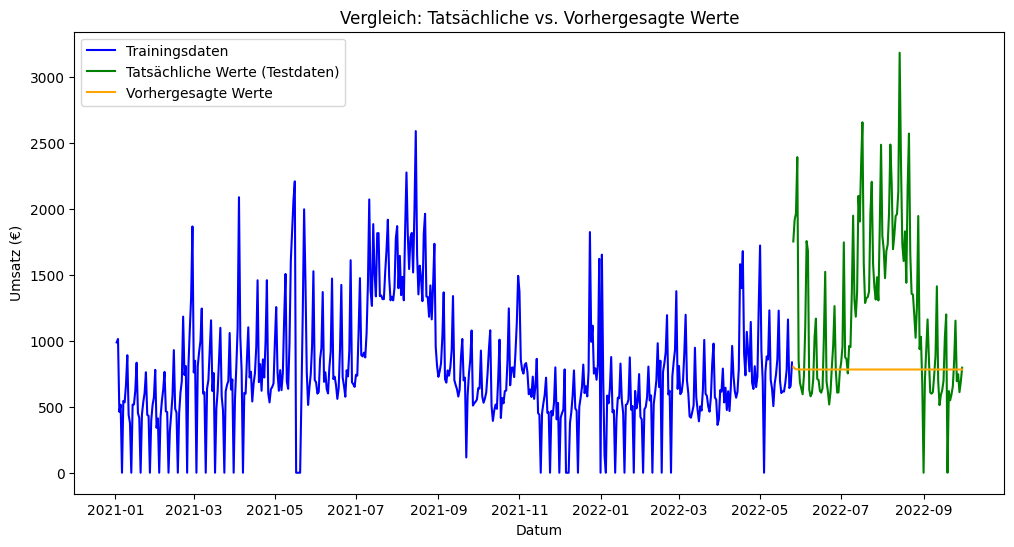

In [165]:
# Frequenz setzen
daily_revenue = daily_revenue.asfreq('D')

# Train-Test-Split
train_size = int(len(daily_revenue) * 0.8)
train, test = daily_revenue.iloc[:train_size], daily_revenue.iloc[train_size:]

# Einfacheres ARIMA-Modell
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Vorhersage erstellen
predictions = arima_result.predict(start=test.index[0], end=test.index[-1])

# Fehlende Werte auffüllen
predictions = predictions.bfill()
test = test.dropna()

# Übereinstimmenden Index sicherstellen
common_index = test.index.intersection(predictions.index)
test = test.loc[common_index]
predictions = predictions.loc[common_index]

# MAE berechnen
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualisierung
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train, label='Trainingsdaten', color='blue')
plt.plot(test, label='Tatsächliche Werte (Testdaten)', color='green')
plt.plot(predictions, label='Vorhergesagte Werte', color='orange')
plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Werte')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


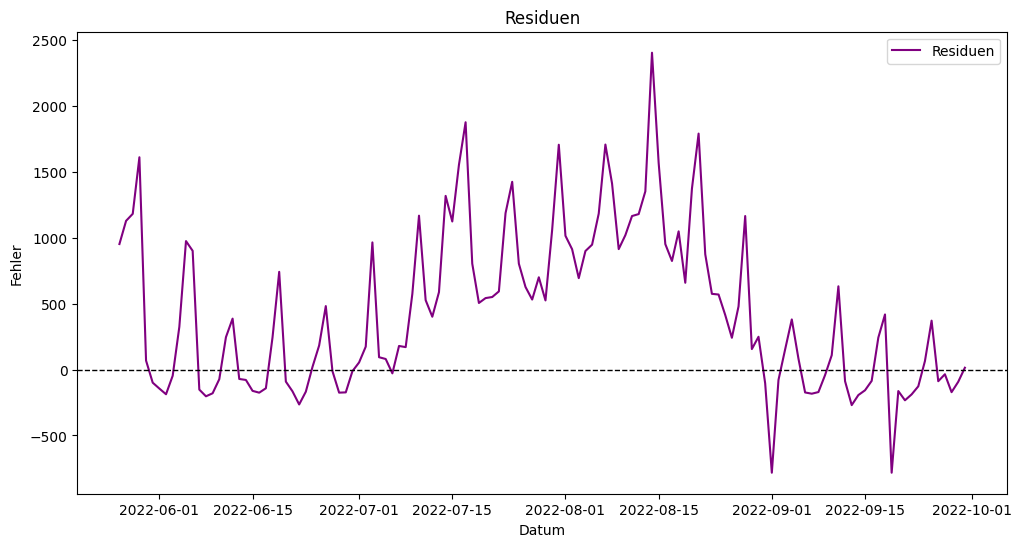

Ljung-Box-Test Ergebnisse:
      lb_stat     lb_pvalue
10  370.97877  1.397862e-73
Die Residuen zeigen Autokorrelation (kein white noise).

Augmented Dickey-Fuller-Test Ergebnisse:
ADF-Statistik: -1.6587596318193083
p-Wert: 0.45247611775077756
Kritische Werte: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Die Residuen sind nicht stationär.


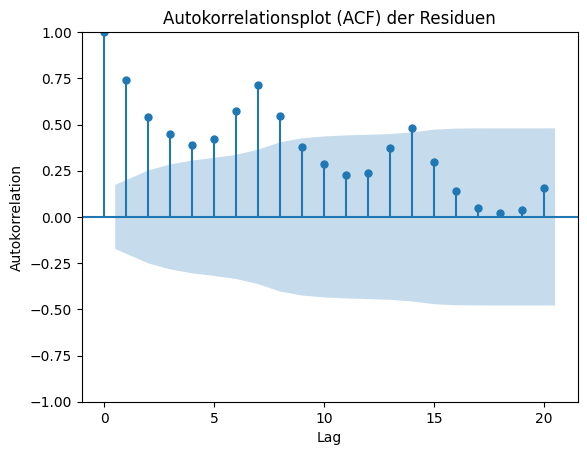

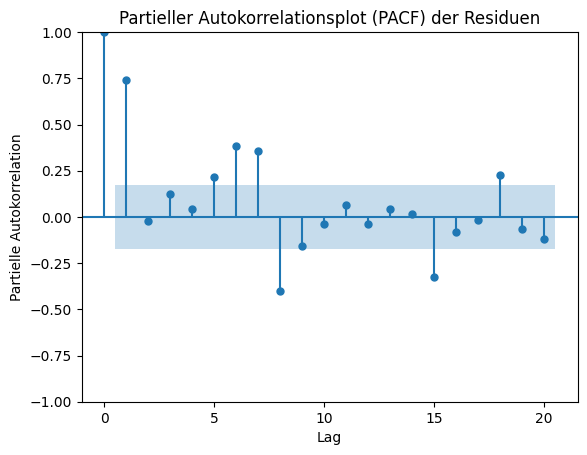

In [167]:
# Residuen berechnen
residuals = test.squeeze() - predictions.squeeze()

# Sicherstellen, dass die Indizes übereinstimmen
common_index = test.index.intersection(predictions.index)
test = test.loc[common_index]
predictions = predictions.loc[common_index]

# Residuen plotten
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuen', color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Residuen')
plt.xlabel('Datum')
plt.ylabel('Fehler')
plt.legend()
plt.show()

# Ljung-Box-Test für White Noise
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box-Test Ergebnisse:")
print(lb_test)

if lb_test['lb_pvalue'].iloc[-1] > 0.05:
    print("Die Residuen sind weißes Rauschen (white noise).")
else:
    print("Die Residuen zeigen Autokorrelation (kein white noise).")

# Augmented Dickey-Fuller-Test für Stationarität
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(residuals.dropna())
print("\nAugmented Dickey-Fuller-Test Ergebnisse:")
print(f"ADF-Statistik: {adf_test[0]}")
print(f"p-Wert: {adf_test[1]}")
print("Kritische Werte:", adf_test[4])

if adf_test[1] > 0.05:
    print("Die Residuen sind nicht stationär.")
else:
    print("Die Residuen sind stationär.")

# Autokorrelationsplots (ACF und PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autokorrelationsplot (ACF)
plot_acf(residuals.dropna(), lags=20)
plt.title('Autokorrelationsplot (ACF) der Residuen')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')
plt.show()

# Partieller Autokorrelationsplot (PACF)
plot_pacf(residuals.dropna(), lags=20, method='ywm')
plt.title('Partieller Autokorrelationsplot (PACF) der Residuen')
plt.xlabel('Lag')
plt.ylabel('Partielle Autokorrelation')
plt.show()


Das Residuum ist weder stationär noch white noise. Es zeigt klare periodische Muster und Autokorrelationen.
Dies bedeutet, dass das aktuelle ARIMA-Modell die Daten nicht vollständig beschreibt. Eine Verbesserung des Modells ist notwendig.

### SARIMA

Mean Absolute Error (MAE) SARIMA: 551.23


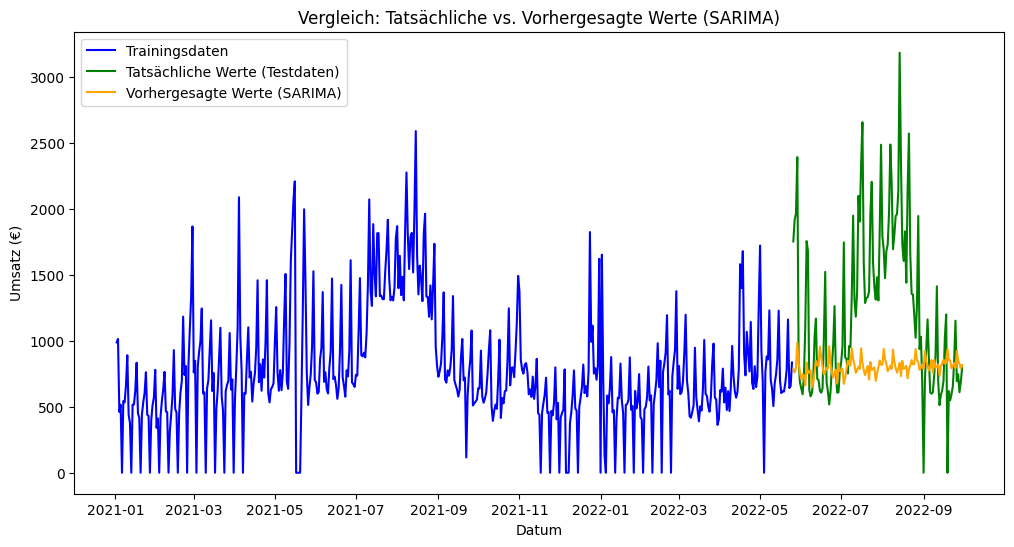

In [171]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Train-Test-Split
train_size = int(len(daily_revenue) * 0.8)
train, test = daily_revenue.iloc[:train_size], daily_revenue.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(2, 1, 2, 12))
sarima_result = sarima_model.fit()

# Vorhersage erstellen
start = test.index[0]
end = test.index[-1]
sarima_predictions = sarima_result.predict(start=start, end=end)

# Fehlende Werte behandeln
sarima_predictions = sarima_predictions.bfill()  # Rückwärtsauffüllen
test = test.dropna()  # NaN-Werte entfernen

# Sicherstellen, dass die Längen übereinstimmen
common_index = test.index.intersection(sarima_predictions.index)
test = test.loc[common_index]
sarima_predictions = sarima_predictions.loc[common_index]

# MAE berechnen
mae_sarima = mean_absolute_error(test, sarima_predictions)
print(f"Mean Absolute Error (MAE) SARIMA: {mae_sarima:.2f}")

# Visualisierung
plt.figure(figsize=(12, 6))
plt.plot(train, label='Trainingsdaten', color='blue')
plt.plot(test, label='Tatsächliche Werte (Testdaten)', color='green')
plt.plot(sarima_predictions, label='Vorhergesagte Werte (SARIMA)', color='orange')
plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Werte (SARIMA)')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


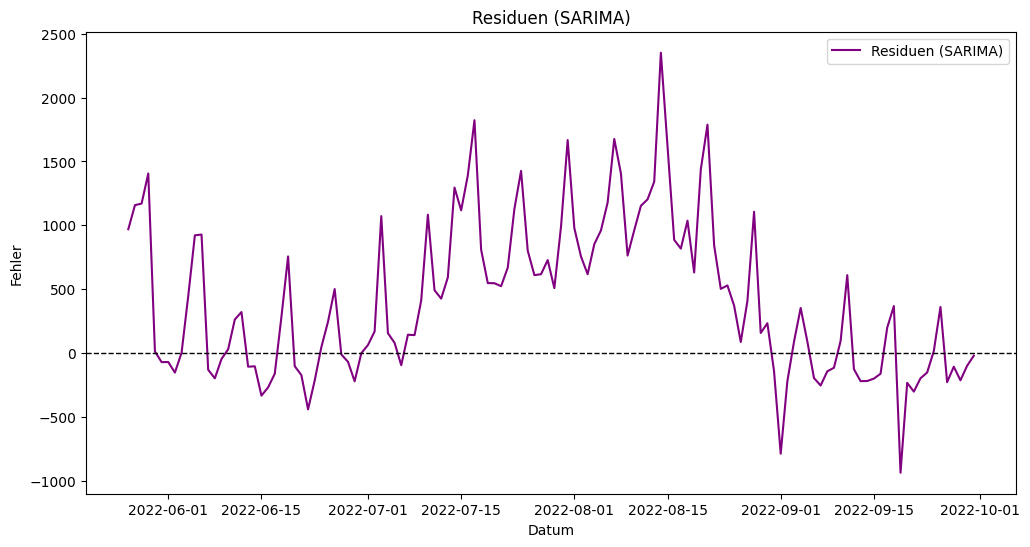

Ljung-Box-Test Ergebnisse (SARIMA):
       lb_stat     lb_pvalue
10  369.945054  2.317992e-73
Die Residuen (SARIMA) zeigen Autokorrelation (kein white noise).

Augmented Dickey-Fuller-Test Ergebnisse (SARIMA):
ADF-Statistik: -1.5979352041553754
p-Wert: 0.4846306118092662
Kritische Werte: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Die Residuen (SARIMA) sind nicht stationär.


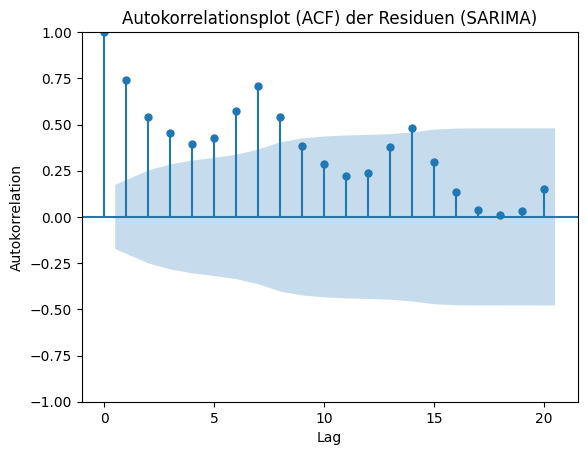

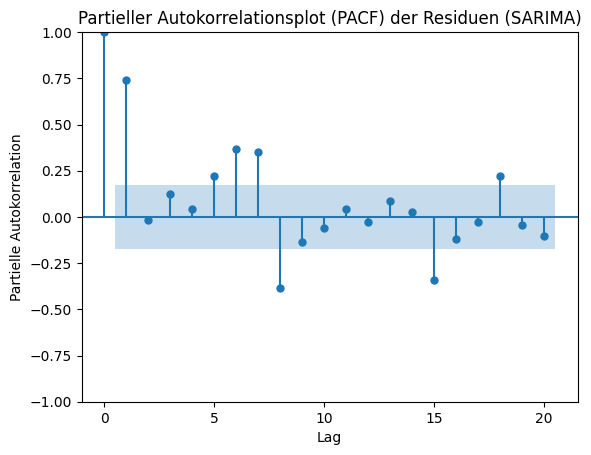

In [172]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuen berechnen
sarima_residuals = test.squeeze() - sarima_predictions.squeeze()

# Residuen plotten
plt.figure(figsize=(12, 6))
plt.plot(sarima_residuals, label='Residuen (SARIMA)', color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Residuen (SARIMA)')
plt.xlabel('Datum')
plt.ylabel('Fehler')
plt.legend()
plt.show()

# 1. Ljung-Box-Test für White Noise
lb_test_sarima = acorr_ljungbox(sarima_residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box-Test Ergebnisse (SARIMA):")
print(lb_test_sarima)

if lb_test_sarima['lb_pvalue'].iloc[-1] > 0.05:
    print("Die Residuen (SARIMA) sind weißes Rauschen (white noise).")
else:
    print("Die Residuen (SARIMA) zeigen Autokorrelation (kein white noise).")

# 2. Augmented Dickey-Fuller-Test (ADF) für Stationarität
adf_test_sarima = adfuller(sarima_residuals.dropna())
print("\nAugmented Dickey-Fuller-Test Ergebnisse (SARIMA):")
print(f"ADF-Statistik: {adf_test_sarima[0]}")
print(f"p-Wert: {adf_test_sarima[1]}")
print("Kritische Werte:", adf_test_sarima[4])

if adf_test_sarima[1] > 0.05:
    print("Die Residuen (SARIMA) sind nicht stationär.")
else:
    print("Die Residuen (SARIMA) sind stationär.")

# 3. Autokorrelationsplots (ACF und PACF)
# Autokorrelationsplot (ACF)
plot_acf(sarima_residuals.dropna(), lags=20)
plt.title('Autokorrelationsplot (ACF) der Residuen (SARIMA)')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')
plt.show()

# Partieller Autokorrelationsplot (PACF)
plot_pacf(sarima_residuals.dropna(), lags=20, method='ywm')
plt.title('Partieller Autokorrelationsplot (PACF) der Residuen (SARIMA)')
plt.xlabel('Lag')
plt.ylabel('Partielle Autokorrelation')
plt.show()


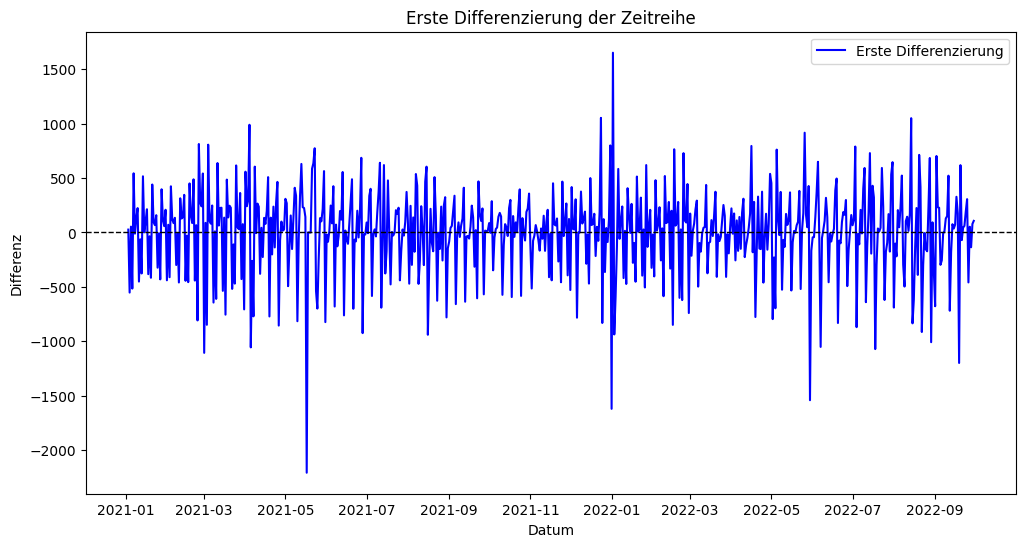

ADF Statistic (Differenzierung): -5.7485994861299785
p-value (Differenzierung): 6.039751047598484e-07
Critical Values (Differenzierung): {'1%': -3.4410277306083668, '5%': -2.8662510413264357, '10%': -2.569278890210853}
Die differenzierte Zeitreihe ist stationär.


In [174]:
# Erste Differenzierung durchführen
diff_1 = daily_revenue.diff().dropna()

# Plot der differenzierten Zeitreihe
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='Erste Differenzierung', color='blue')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Erste Differenzierung der Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.legend()
plt.show()

# ADF-Test für die differenzierte Zeitreihe
adf_test_diff_1 = adfuller(diff_1)
print("ADF Statistic (Differenzierung):", adf_test_diff_1[0])
print("p-value (Differenzierung):", adf_test_diff_1[1])
print("Critical Values (Differenzierung):", adf_test_diff_1[4])

if adf_test_diff_1[1] > 0.05:
    print("Die differenzierte Zeitreihe ist nicht stationär.")
else:
    print("Die differenzierte Zeitreihe ist stationär.")


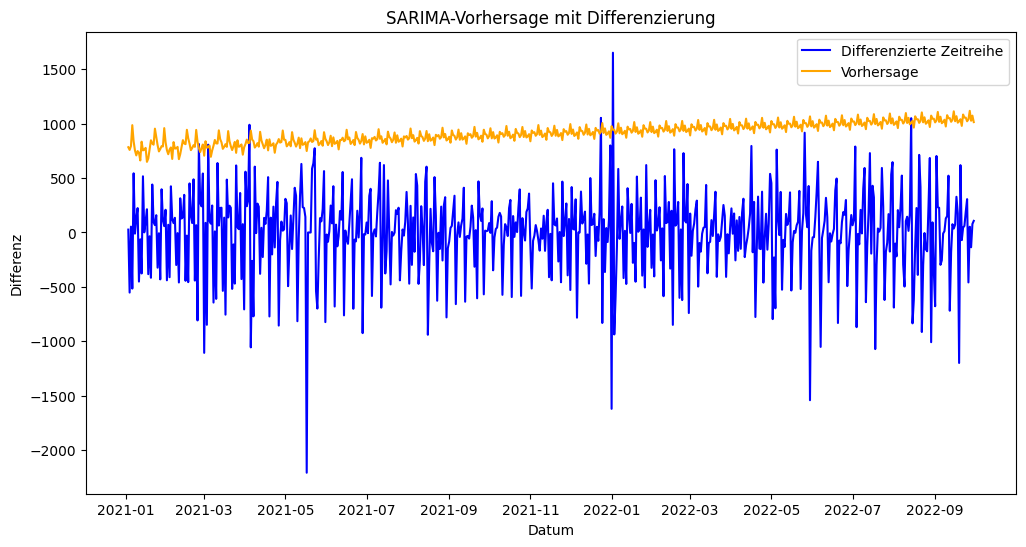

In [176]:
forecast = sarima_result.get_forecast(steps=len(diff_1))
forecast_values = forecast.predicted_mean

# Plot der Vorhersage
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='Differenzierte Zeitreihe', color='blue')
plt.plot(diff_1.index, forecast_values, label='Vorhersage', color='orange')
plt.title('SARIMA-Vorhersage mit Differenzierung')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.legend()
plt.show()


### Hinzufügen von Features

In [178]:
df_bakery_raw

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price,revenue
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90,0.90
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,1.15,1.15
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00
...,...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,0.15,0.15
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,1.20,1.20
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,0.15,0.30
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,1.30


In [179]:
# Konvertiere die Spalte 'date' in ein Datumsformat
df_bakery_raw['date'] = pd.to_datetime(df_bakery_raw['date'])

# Bestimme das Start- und Enddatum aus df_bakery_raw
start_date = df_bakery_raw['date'].min().strftime('%Y-%m-%d')
end_date = df_bakery_raw['date'].max().strftime('%Y-%m-%d')

print("Startdatum:", start_date)
print("Enddatum:", end_date)


Startdatum: 2021-01-02
Enddatum: 2022-09-30


In [180]:
from pytrends.request import TrendReq

# Pytrends-Objekt erstellen
pytrends = TrendReq()



# Interesse an "Brot" abfragen
pytrends.build_payload(kw_list=["bread"], timeframe=f'{start_date} {end_date}')
trends_data = pytrends.interest_over_time()

# Google-Trends-Daten hinzufügen
daily_revenue['google_trends_bread'] = trends_data['bread'].reindex(daily_revenue.index, fill_value=0)

daily_revenue

,revenue,google_trends_bread
date,,
2021-01-02,987.85,0
2021-01-03,1014.30,90
2021-01-04,461.90,0
2021-01-05,515.70,0
2021-01-06,0.00,0
...,...,...
2022-09-26,693.75,0
2022-09-27,746.45,0
2022-09-28,610.70,0


In [182]:
import wbdata


# Zeitrahmen definieren
start_date = datetime.datetime(2021, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# Abrufen der globalen Inflationsrate
global_inflation = wbdata.get_dataframe(indicators={'FP.CPI.TOTL.ZG': 'inflation'},
                                        country='WLD',  # Code für weltweite Daten
                                        data_date=(start_date, end_date),
                                        convert_date=True)

# Integration in daily_revenue
daily_revenue['inflation'] = global_inflation['inflation'].reindex(daily_revenue.index, method='nearest')

# Ausgabe der ersten Zeilen
print(daily_revenue['inflation'].head())


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
# Korrelation prüfen

In [ ]:
# Cranger Cause prüfen

### LSTM

# Empfehlung